In [43]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

jungang_col = keti_db.jungang_pattern
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, EPOCHS = 20,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[
                    tf.metrics.MeanAbsoluteError(),
                    
                ])

  history = model.fit(window.train, epochs=EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [3]:
jungang_db_cur = jungang_col.find()
db_datas = [_ for _ in jungang_db_cur]

jg_datas = pd.DataFrame(columns=['Date Time','energy (kw 15min)'])
jg_datas['Date Time'] = [_['ttime'] for _ in db_datas]
jg_datas['energy (kw 15min)'] = [_['energy'] for _ in db_datas]

date_time = pd.to_datetime(jg_datas.pop('Date Time'),
                          format="%Y-%m-%d %H:%M:%S")
jg_datas.index = date_time


# 불 필요 데이터 잘라내기
idx = jg_datas.index.get_loc(jg_datas[jg_datas['energy (kw 15min)'] == 0].index[7])

jg_datas = jg_datas.iloc[:idx].copy()
jg_datas

,energy (kw 15min)
Date Time,
2017-01-01 00:00:00,15250
2017-01-01 00:15:00,15250
2017-01-01 00:30:00,13750
2017-01-01 00:45:00,14250
2017-01-01 01:00:00,14000
...,...
2018-09-19 22:45:00,18750
2018-09-19 23:00:00,18250
2018-09-19 23:15:00,18000


In [4]:
def calc_sin(ts, target_value):
    return np.sin(ts * (2 * np.pi / target_value)).values
def calc_cos(ts, target_value):
    return np.cos(ts * (2 * np.pi / target_value)).values
def get_season(month):
    if month in [3,4,5]:
        return "봄"
    elif month in [6,7,8]:
        return "여름"
    elif month in [9,10,11]:
        return "가을"
    else:
        return "겨울"
def get_season_to_idx(season):
    if season == "봄":
        return 1
    elif season == "여름":
        return 2
    elif season == "가을":
        return 3
    elif season == "겨울":
        return 4

# ~ 2018 year data parsing
jg_datas = jg_datas[jg_datas.index.year <= 2018]
date_time = jg_datas.index
timestamp = date_time.map(dt.timestamp)

day = 24 * 60 * 60
week = 7 * day
year = (365) * day

jg_datas['week sin'] = calc_sin(timestamp, week)
jg_datas['week cos'] = calc_cos(timestamp, week)
jg_datas['year sin'] = calc_sin(timestamp, year)
jg_datas['year cos'] = calc_cos(timestamp, year)
jg_datas['season'] = [get_season(_.month) for _ in jg_datas.index]
jg_datas['season idx'] = [get_season_to_idx(_) for _ in jg_datas['season'].values]

jg_datas = jg_datas[::4]
jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx
Date Time,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4
...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3


In [5]:
all_dict = dict()
train_type = ['univariate', 
              'multivariate', 
#               'season univariate', 
#               'season multivariate', 
              'multivariate (week)', 
              'multivariate (season)',              
              'multivariate (week-season)',              
              'with cluster label',
              'with cluster label (multivariate)',
              'with cluster label (multivariate-week)',
              'with cluster label (multivariate-season)',
              'with cluster label (multivariate-week-season)'              
             ]
uni_columns = ['energy (kw 15min)']
mul_week_columns = ['energy (kw 15min)', 'week sin', 'week cos']
mul_only_season_columns = ['energy (kw 15min)', 'season idx']
mul_season_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'season idx']
mul_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'year sin', 'year cos']
seasons = ["봄", "여름", "가을", "겨울"]

# Clusterinbg 가져오기 작업
cur_cluster_result = cluster_col.find({
    "uid": "jungang_pattern"
})
cluster_result = dict()

for data in cur_cluster_result:
    in_dict = pd.DataFrame(columns=['Label', 'Weekday'])
    in_dict.index.name = "Date Time"
    
    season = data['season']
    infos = data['info']
    
    dtime = [dt.strptime(_['date'], "%Y-%m-%d") for _ in infos]
    labels = [_['label'] for _ in infos]

    for idx, _ in enumerate(dtime):
        label = labels[idx]        
        in_dict.loc[_] = [label, _.weekday()]
        
    cluster_result[season] = in_dict
    
cluster_pattern_dict = dict()

for season in seasons:
    result = cluster_result[season]
    in_dict = pd.DataFrame(columns=[_ for _ in range(0, 24)])
    in_dict.index.name = "Label"
    
    labels = list(set(result['Label']))
    for label in labels:
        cluster_pattern = np.array([])
        date_in_labels = result[result['Label'] == label].index
        for date in date_in_labels:
            idx = jg_datas.index.get_loc(date)
            pattern = jg_datas.iloc[idx: idx+24]['energy (kw 15min)'].values
            cluster_pattern = np.append(cluster_pattern, pattern)
        cluster_pattern = cluster_pattern.reshape(-1,24).mean(axis=0)
        in_dict.loc[label] = cluster_pattern
        
    cluster_pattern_dict[season] = in_dict
    
# Clustering Matching
cluster_dist_dict = dict()
for season in cluster_result.keys():
    cluster_season_dict = dict()
    week_list = set(cluster_result[season]['Weekday'])
    for week in week_list:
        week_dist = cluster_result[season][
            cluster_result[season]['Weekday'] == week
        ]['Weekday'].groupby(cluster_result[season]['Label']).count().sort_values(ascending=False)
        week_top_label = week_dist.index[0]
        
        cluster_season_dict[week] = week_top_label
    cluster_dist_dict[season] = cluster_season_dict

In [6]:
cluster_pattern_col = pd.DataFrame(columns=['cluster energy'])
for idx in range(0, len(jg_datas), 24):
    datas = jg_datas.iloc[idx: idx + 24].copy()
    date = datas.index[0]
    
    season = get_season(date.month)
    weekday = date.weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_pattern_dict[season].loc[label].values
    
    for idx, _ in enumerate(datas.index):
        cluster_pattern_col.loc[_] = c_pattern[idx]
        
cluster_pattern_col

,cluster energy
2017-01-01 00:00:00,18390.625000
2017-01-01 01:00:00,17125.000000
2017-01-01 02:00:00,16265.625000
2017-01-01 03:00:00,22843.750000
2017-01-01 04:00:00,19328.125000
...,...
2018-09-19 19:00:00,19027.777778
2018-09-19 20:00:00,13638.888889
2018-09-19 21:00:00,11486.111111
2018-09-19 22:00:00,10638.888889


In [7]:
day_1_size = 24
year_half_size = day_1_size * int(365 / 4) 
year_1_size = day_1_size * 365

training_datas = jg_datas[:year_1_size]
validation_datas = jg_datas[year_1_size:
                        year_1_size + year_half_size]
testing_datas = jg_datas[year_1_size + year_half_size:]

In [8]:
for t_type in train_type:
    if 'week-season' in t_type:
        in_dict = dict()
        in_col = mul_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
#     if 'season' in t_type:
#         seasons_dict = dict()
#         for season in seasons:
#             season_dict = dict()
#             in_col = mul_columns if "multivariate" in t_type else uni_columns
            
#             season_dict['train'] = training_datas[in_col][training_datas['season'] == season].copy()
#             season_dict['val'] = validation_datas[in_col].copy()
#             season_dict['test'] = testing_datas[in_col].copy()
            
#             seasons_dict[season] = season_dict
#         all_dict[t_type] = seasons_dict
    elif 'season' in t_type:
        in_dict = dict()
        in_col = mul_only_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'week' in t_type:
        in_dict = dict()
        in_col = mul_week_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    else:
        in_dict = dict()
        in_col = mul_columns if "multivariate" in t_type else uni_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict

In [9]:
norm_all_dict = dict()

mean = training_datas.mean()
std = training_datas.std()

for key in all_dict.keys():
#     in_col = mul_week_columns if "week" in key else mul_season_columns if "season" in key else mul_columns if "multivariate" in key else uni_columns
#     in_col = uni_columns if "univariate" in key else mul_columns
    
    in_col = None
    
    if "week-season" in key:
        in_col = mul_season_columns
    elif "season" in key:
        in_col = mul_only_season_columns
    elif "week" in key:
        in_col = mul_week_columns
    elif "multivariate" in key:
        in_col = mul_columns
    else:
        in_col = uni_columns
        
    in_dict = all_dict[key].copy()
    m = mean[in_col]
    s = std[in_col]

    train = in_dict['train'].copy()
    val = in_dict['val'].copy()
    test = in_dict['test'].copy()

    in_dict['train'] = (train - m) / s
    in_dict['val'] = (val - m) / s
    in_dict['test'] = (test - m) / s
#     if "season" in key:
#         for season in seasons:
#             train = in_dict[season]['train'].copy()
#             val = in_dict[season]['val'].copy()
#             test = in_dict[season]['test'].copy()
            
#             in_dict[season]['train'] = (train - m) / s
#             in_dict[season]['val'] = (val - m) / s
#             in_dict[season]['test'] = (test - m) / s
#     else:
#         train = in_dict['train'].copy()
#         val = in_dict['val'].copy()
#         test = in_dict['test'].copy()
        
#         in_dict['train'] = (train - m) / s
#         in_dict['val'] = (val - m) / s
#         in_dict['test'] = (test - m) / s
        
    norm_all_dict[key] = in_dict

In [10]:
for key in norm_all_dict.keys():
    if "with cluster" in key:
        mean = all_dict[key]['train'].mean().values[0]
        std = all_dict[key]['train'].std().values[0]
        
        norm_cluster_pattern_col = (cluster_pattern_col.copy() - mean) / std
        c_norm_dict = norm_all_dict[key].copy()
        
        for c_key in c_norm_dict.keys():
            c_norm_dict[c_key]['cluster energy'] = norm_cluster_pattern_col['cluster energy']
        
        
        norm_all_dict[key] = c_norm_dict.copy()

In [11]:
windows = dict()

for key in norm_all_dict.keys():
    nad = norm_all_dict[key]
    
#     if "season" in key:
#         seasons_window = dict()
#         for season in seasons:
#             season_window = dict()
#             for WINDOW_WIDTH in range(3, 21):
#                 h_key = "{} hours".format(WINDOW_WIDTH)
#                 season_window[h_key] = WindowGenerator(
#                         input_width=WINDOW_WIDTH,
#                         label_width=1,
#                         shift=1,
#                         label_columns=uni_columns,
#                         train_df=nad[season]['train'],
#                         val_df=nad[season]['val'],
#                         test_df=nad[season]['test']
#                     )
#             seasons_window[season] = season_window
#         windows[key] = seasons_window
#     else:
    window = dict()
    for WINDOW_WIDTH in range(3, 21):
        h_key = "{} hours".format(WINDOW_WIDTH)
        window[h_key] = WindowGenerator(
                    input_width=WINDOW_WIDTH,
                    label_width=1,
                    shift=1,
                    label_columns=uni_columns,
                    train_df=nad['train'],
                    val_df=nad['val'],
                    test_df=nad['test']
                )
    windows[key] = window

In [15]:
cluster_windows = windows['with cluster label']['3 hours']

In [20]:
norm_all_dict['with cluster label']['train']

,energy (kw 15min),cluster energy
Date Time,,
2017-01-01 00:00:00,-0.719354,-0.488868
2017-01-01 01:00:00,-0.811090,-0.581751
2017-01-01 02:00:00,-0.756048,-0.644819
2017-01-01 03:00:00,0.326432,-0.162060
2017-01-01 04:00:00,-0.682660,-0.420066
...,...,...
2017-12-31 19:00:00,-1.196379,0.803458
2017-12-31 20:00:00,-1.141338,0.703695
2017-12-31 21:00:00,-1.214726,0.583292


In [17]:
cluster_windows.example

(<tf.Tensor: shape=(32, 3, 2), dtype=float32, numpy=
 array([[[-0.77439535, -0.23899284],
         [-0.8294367 , -0.33323035],
         [-0.84778386, -0.35908312]],
 
        [[-0.8294367 , -0.33323035],
         [-0.84778386, -0.35908312],
         [-0.84778386,  0.0962592 ]],
 
        [[-0.84778386, -0.35908312],
         [-0.84778386,  0.0962592 ],
         [-0.8294367 , -0.05635553]],
 
        [[-0.84778386,  0.0962592 ],
         [-0.8294367 , -0.05635553],
         [-0.77439535,  0.4423527 ]],
 
        [[-0.8294367 , -0.05635553],
         [-0.77439535,  0.4423527 ],
         [-0.7010068 ,  0.5807901 ]],
 
        [[-0.77439535,  0.4423527 ],
         [-0.7010068 ,  0.5807901 ],
         [-0.5358827 ,  1.0277928 ]],
 
        [[-0.7010068 ,  0.5807901 ],
         [-0.5358827 ,  1.0277928 ],
         [-0.11389879,  1.529003  ]],
 
        [[-0.5358827 ,  1.0277928 ],
         [-0.11389879,  1.529003  ],
         [ 0.34477937,  2.0385528 ]],
 
        [[-0.11389879,  1.529003  ]

In [21]:
# Cluster WindowGenerator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.v_t_label_columns = label_columns
    self.label_columns = ['cluster energy']
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def v_t_split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.v_t_label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.v_t_split_window = v_t_split_window
WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def v_t_make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.v_t_split_window)

  return ds

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.v_t_make_dataset = v_t_make_dataset
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.v_t_make_dataset(self.val_df)

@property
def test(self):
  return self.v_t_make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, EPOCHS = 20,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[
                    tf.metrics.MeanAbsoluteError(),
                    
                ])

  history = model.fit(window.train, epochs=EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
clus

In [27]:
cluster_window = WindowGenerator(
                    input_width=3,
                    label_width=1,
                    shift=1,
                    label_columns=uni_columns,
                    train_df=norm_all_dict['with cluster label']['train'],
                    val_df=norm_all_dict['with cluster label']['val'],
                    test_df=norm_all_dict['with cluster label']['test'])

In [38]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
    tf.keras.layers.Dense(
        units=1
    )
])
compile_and_fit(lstm_model, cluster_window, 50)

Epoch 1/50
274/274 [==============================] - 3s 4ms/step - loss: 0.3988 - mean_absolute_error: 0.4800 - val_loss: 1.5399 - val_mean_absolute_error: 1.0870
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2008 - mean_absolute_error: 0.3326 - val_loss: 1.6707 - val_mean_absolute_error: 1.1458
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1858 - mean_absolute_error: 0.3155 - val_loss: 1.7474 - val_mean_absolute_error: 1.1728


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

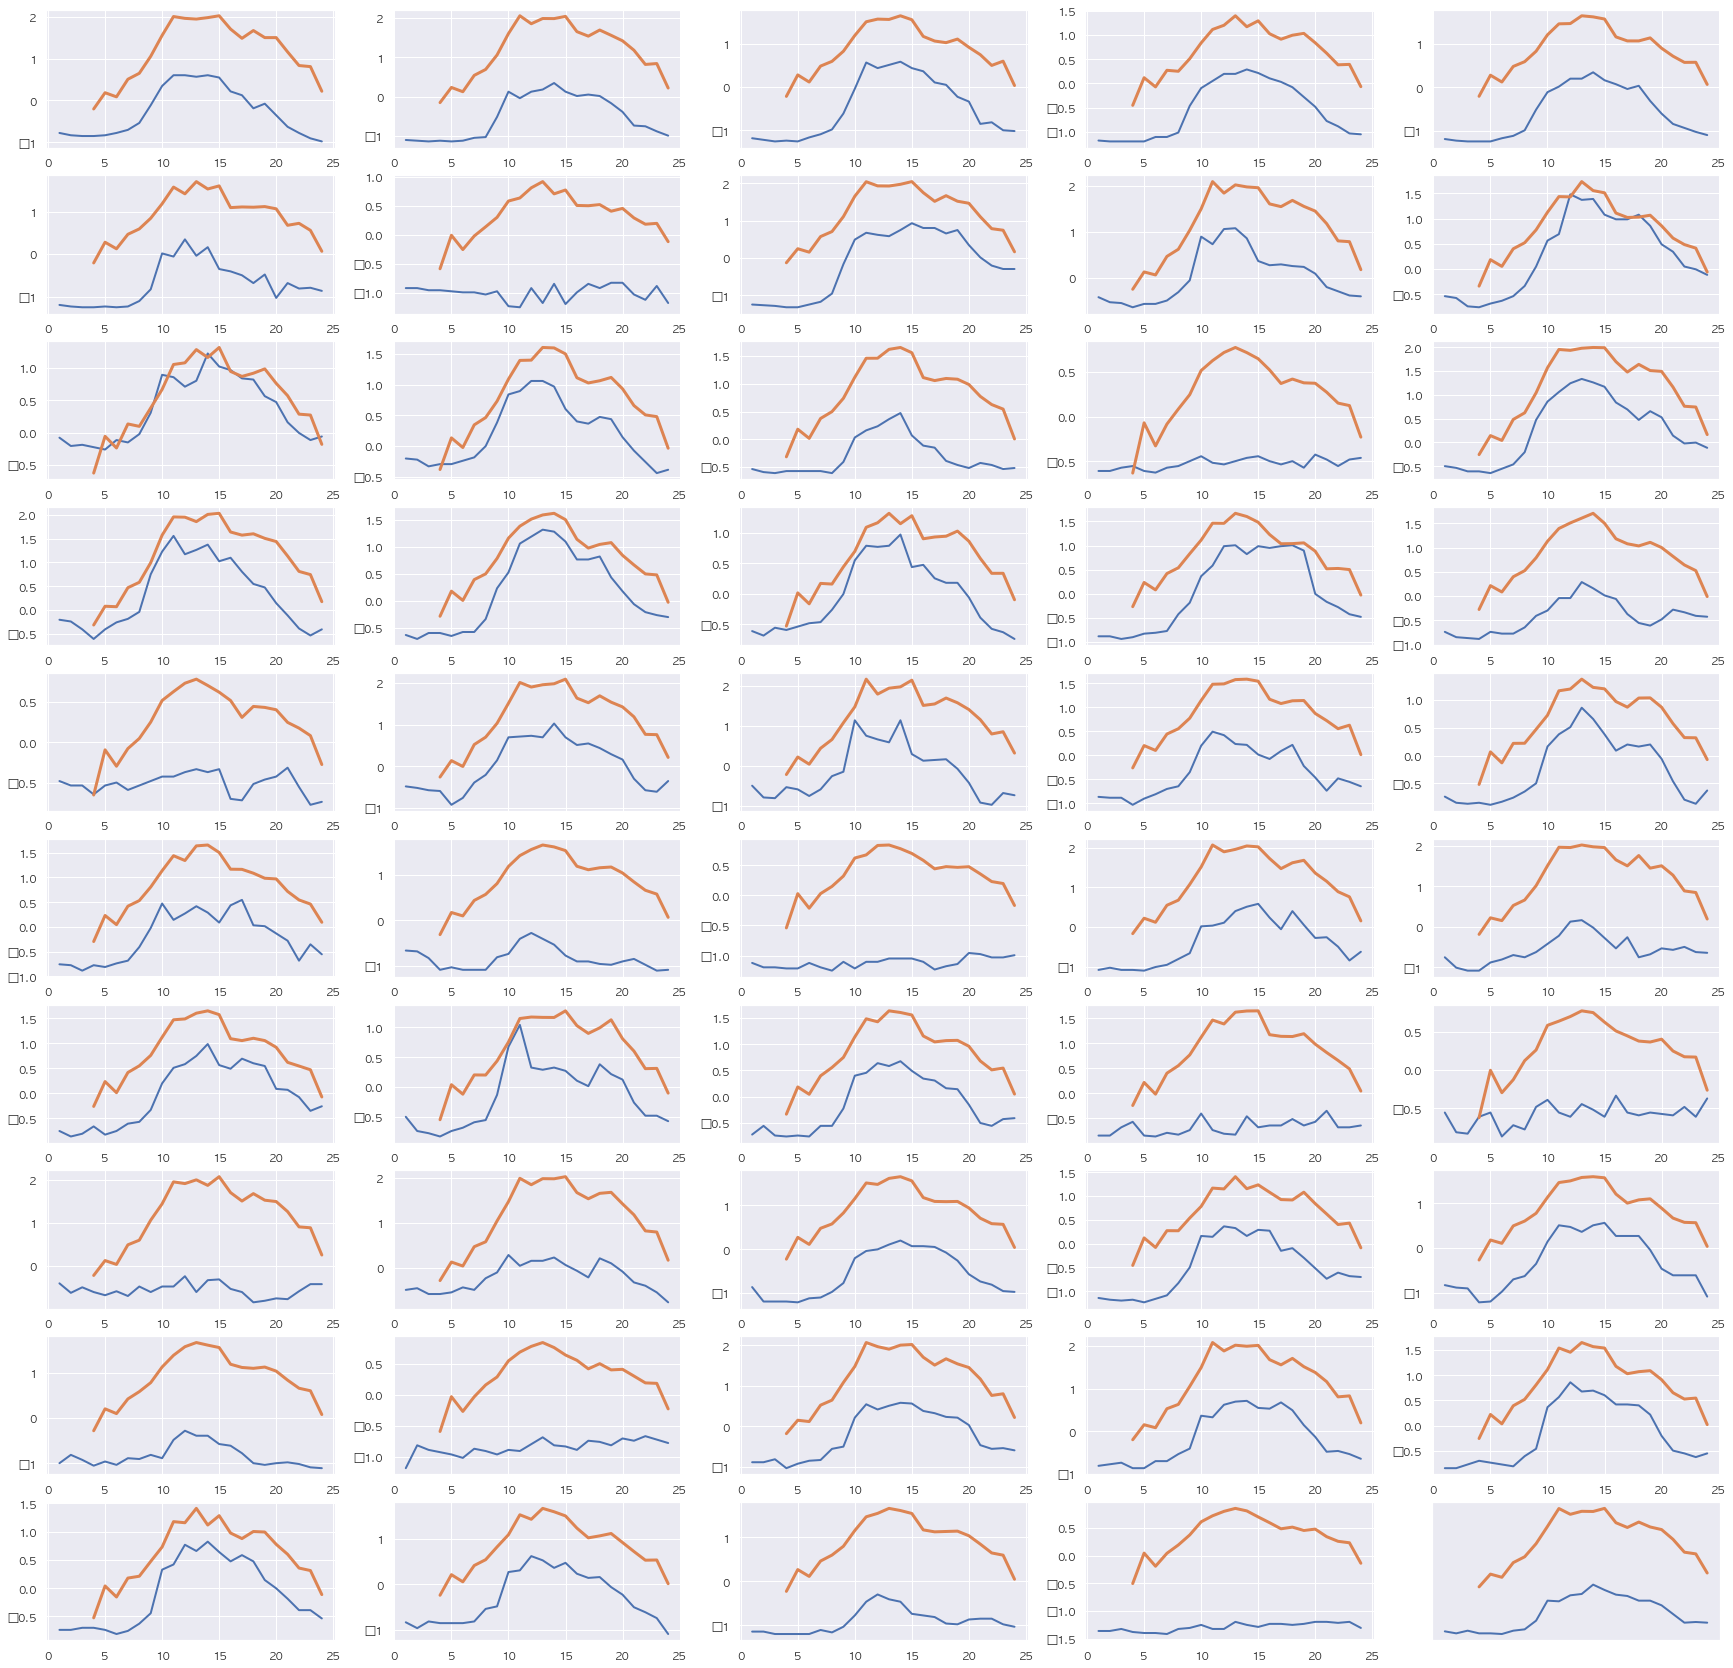

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8

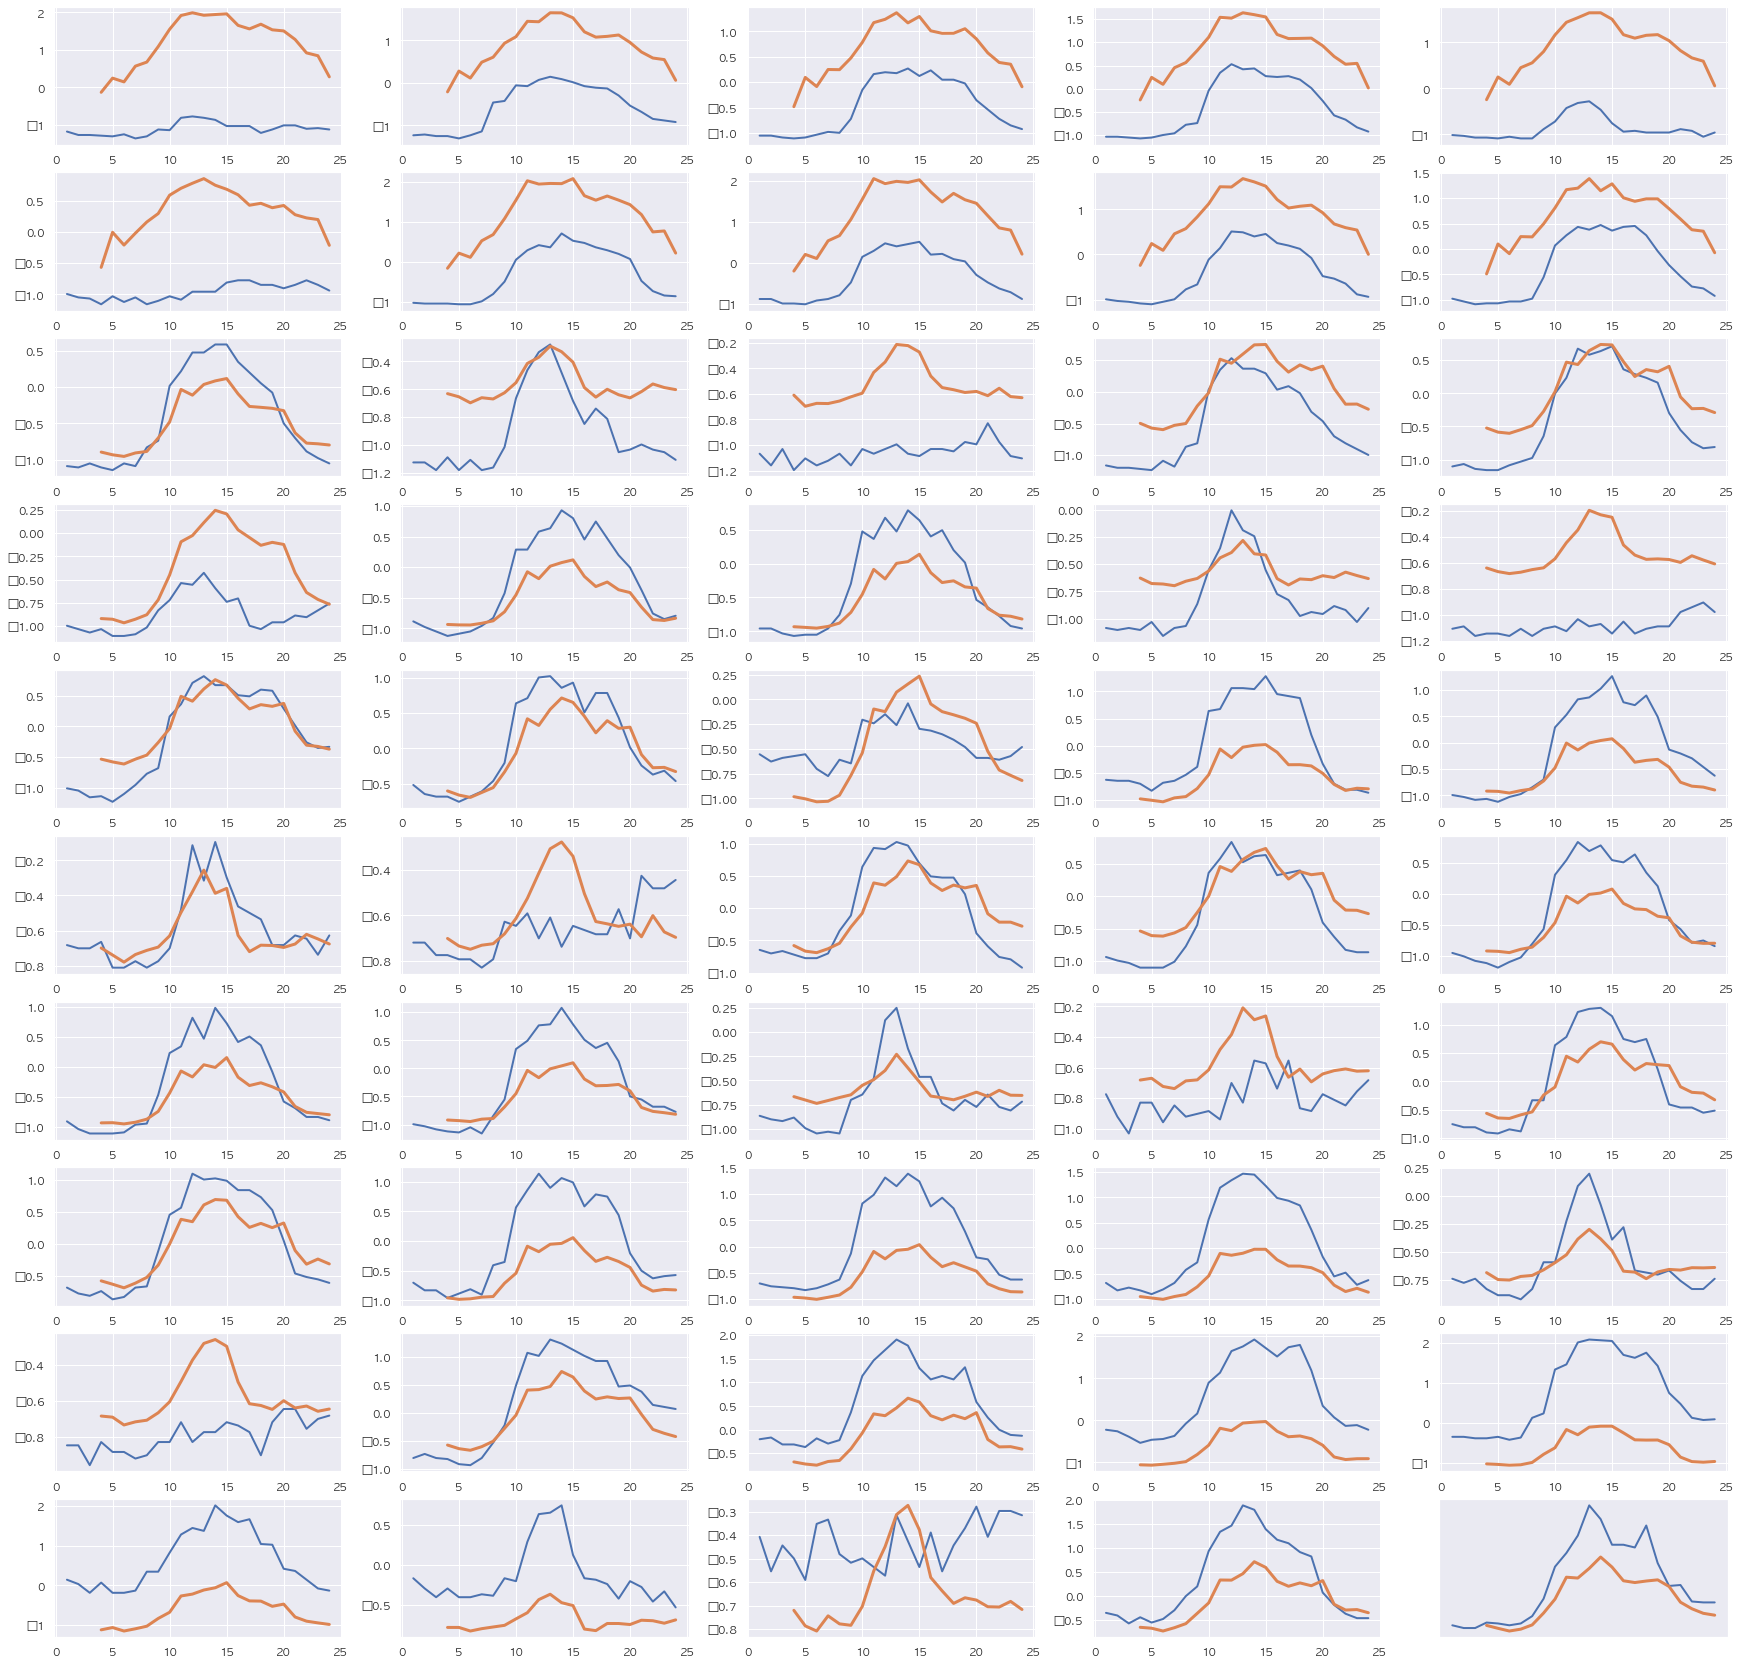

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


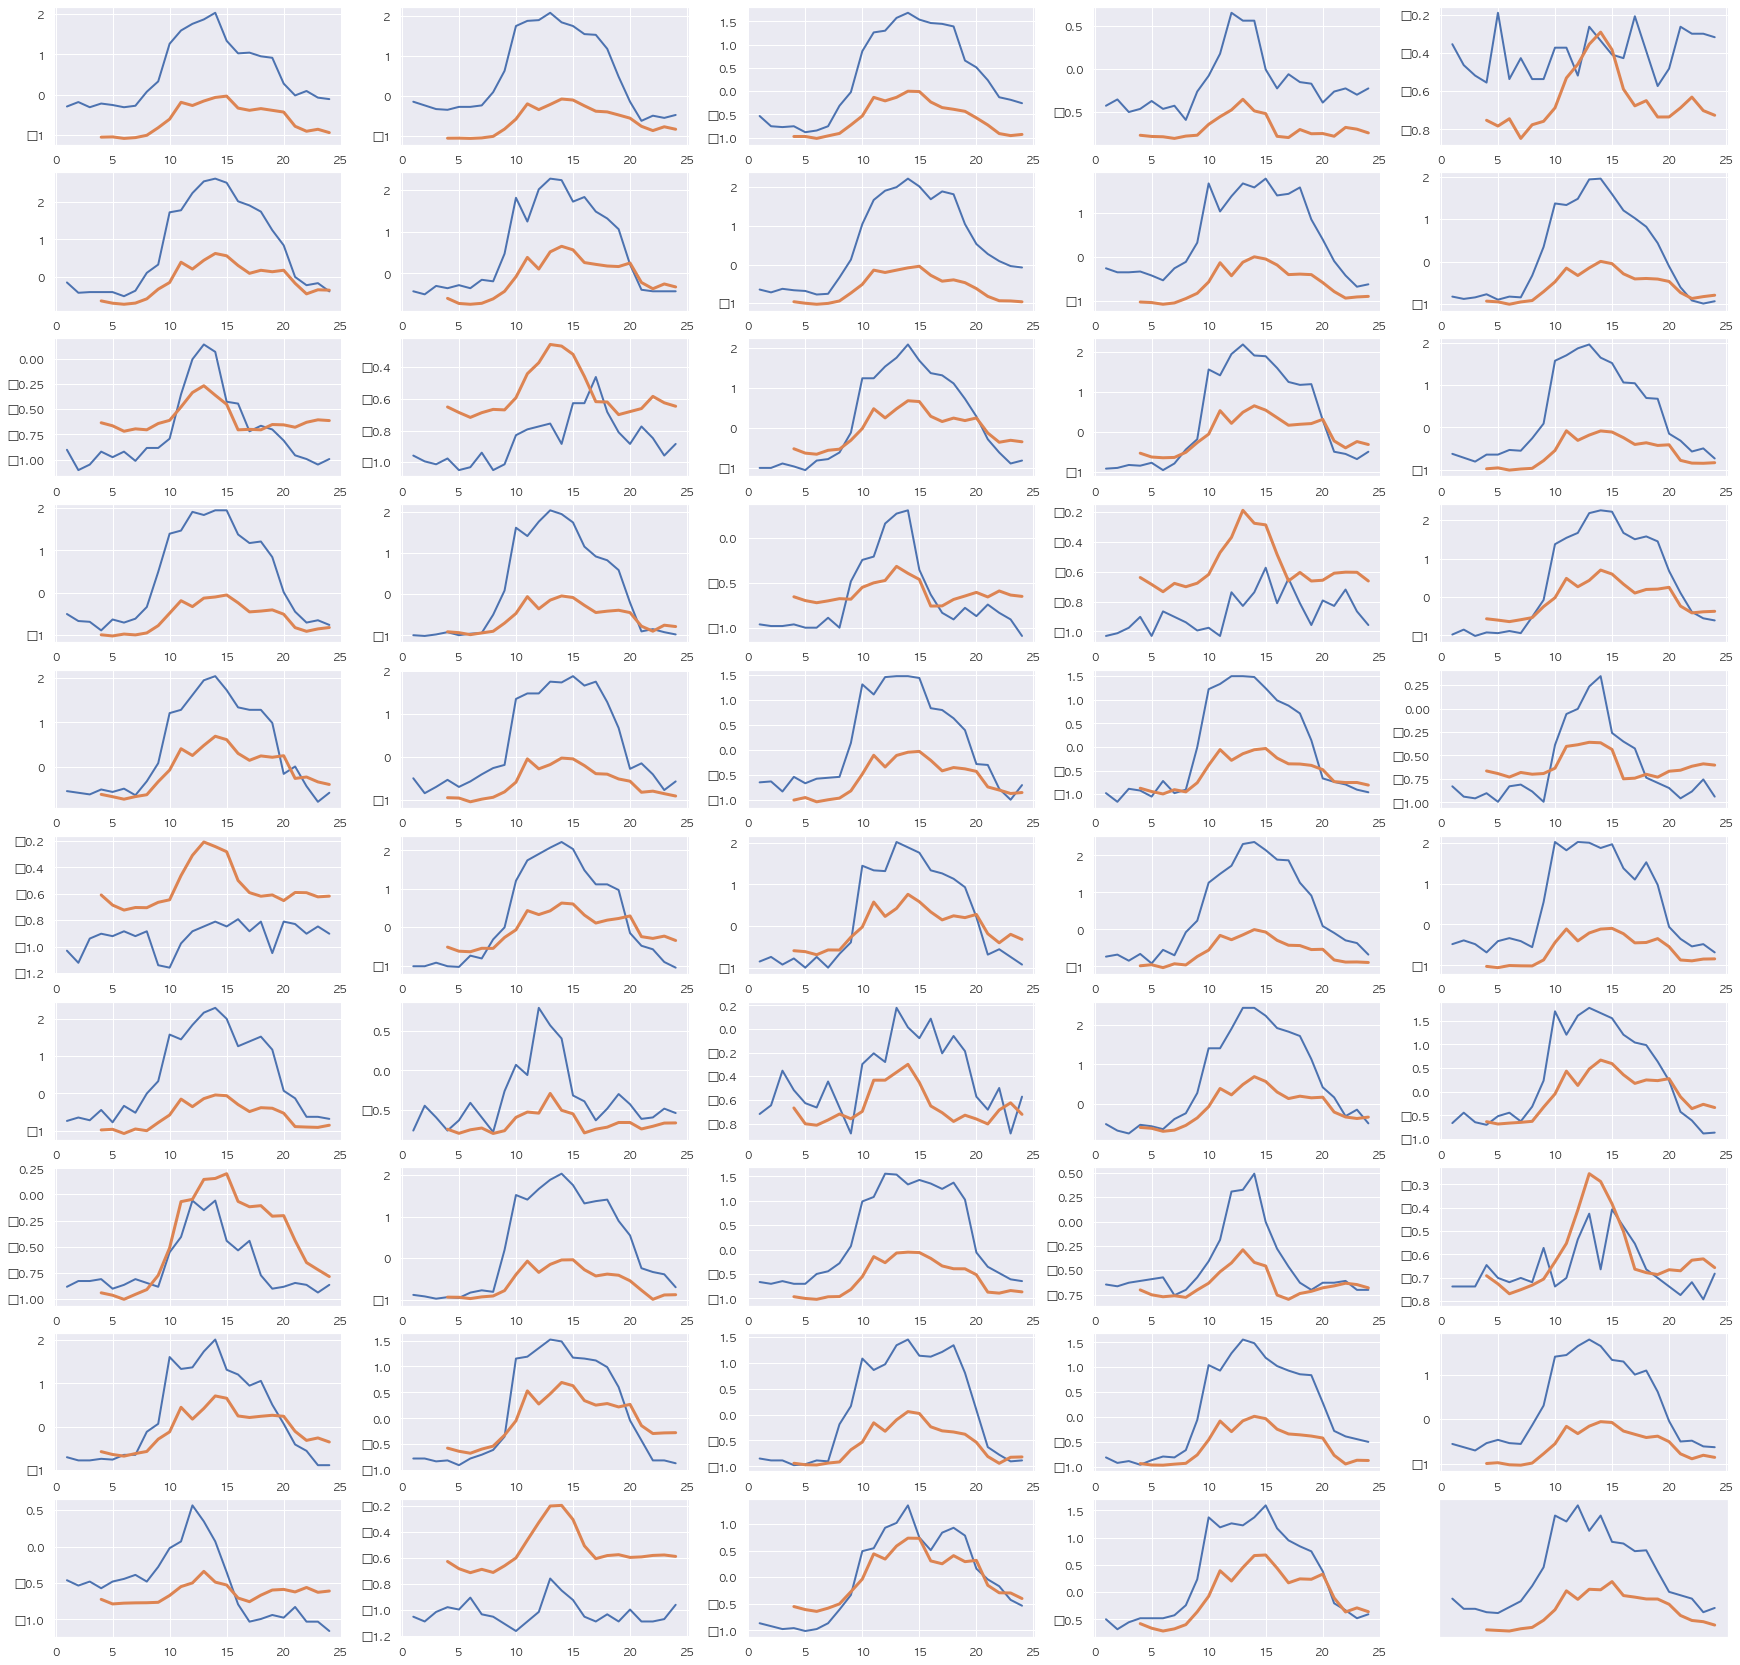

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

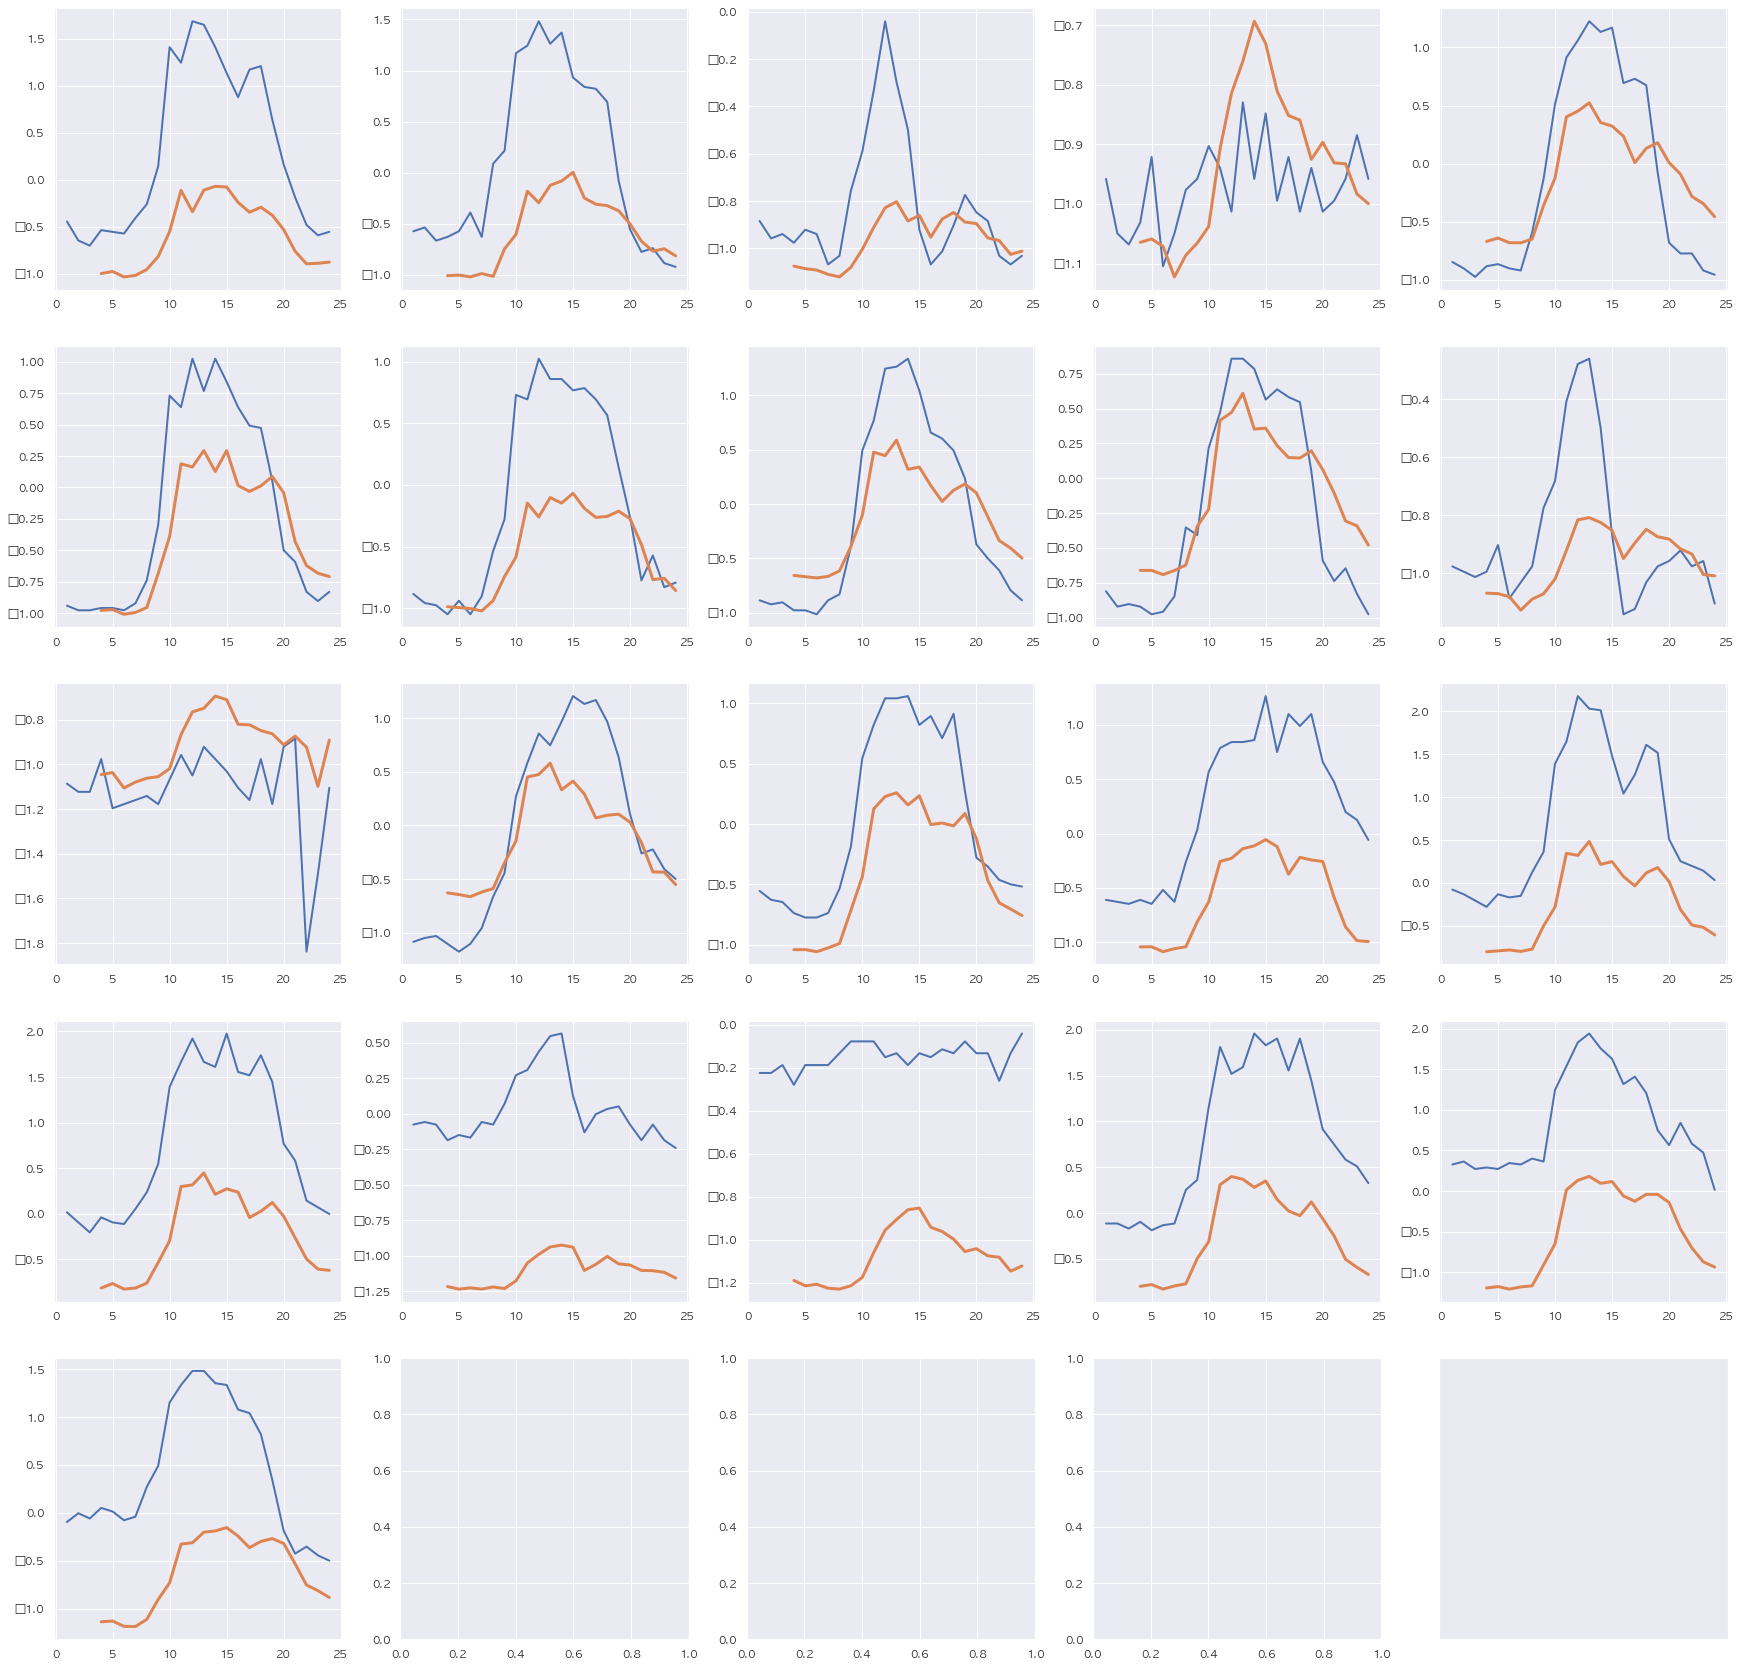

In [42]:
predict_data_length = 3

for _ in range(0, round(len(norm_all_dict['univariate']['test']) / 24), 50):
    test_df = norm_all_dict['with cluster label']['test'][_ * 24:(_ + 50) * 24]
    feature_length = len(test_df.columns)
    
    fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    cnt = 0

    for split in range(0, round(len(test_df)), 24):
        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
            inputs = inputs.reshape(-1, predict_data_length, feature_length)
            result = lstm_model(inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        sns.lineplot(original_x_labels, original, lw=2, ax=axes[
            math.floor(cnt / 5)
        ][math.floor(cnt % 5)])
        sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
            math.floor(cnt / 5)
        ][math.floor(cnt % 5)])

        cnt += 1
    plt.show()

In [58]:
weather_df = pd.DataFrame(columns=['avg ta', 'avg rhm'])
for weather in weather_col.find():
    for hours in range(0,24):
        weather_df = weather_df.append({
            'avg ta': weather['avgTa'],
            'avg rhm': weather['avgRhm']
        }, ignore_index = True)

In [59]:
weather_df

,avg ta,avg rhm
0,2.7,75.9
1,2.7,75.9
2,2.7,75.9
3,2.7,75.9
4,2.7,75.9
...,...,...
17515,-5.4,39.6
17516,-5.4,39.6
17517,-5.4,39.6
17518,-5.4,39.6


In [66]:
jg_datas['avg ta'] = weather_df['avg ta'].values[:15048]
jg_datas['avg rhm'] = weather_df['avg rhm'].values[:15048]

In [67]:
jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx,avg ta,avg rhm
Date Time,,,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4,2.7,75.9
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4,2.7,75.9
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4,2.7,75.9
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4,2.7,75.9
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4,2.7,75.9
...,...,...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3,22.1,59.1
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3,22.1,59.1
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3,22.1,59.1
